**NOTES**: 
1. Module load BEDTools before running notebook:
    * Load using `module load BEDTools`  
2. Add the `bedGraphToBigWig` tool to your PATH before running notebook:
    * It can be downloaded from http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/ or found at `/fh/fast/setty_m/grp/tools/bedGraphToBigWig`
    * Add to PATH with: `PATH=/fh/fast/setty_m/grp/tools/:$PATH`

# Imports

In [1]:
import os
import pandas as pd
import numpy as np

import scanpy as sc
import pyranges as pr
import warnings

import gzip
import subprocess
import tabix


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# config for matplotlib
%matplotlib inline
sc.set_figure_params(frameon=False, color_map = 'Spectral_r')
sns.set_style('white')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'


# Parameters

In [4]:
# # ATAC anndata objects
# atac_ad

# # Output and scratch directories
# out_dir
# tmp_dir 


# # Grouping parameters 
# # Sample field in atac_ad.obs (Useful in case your anndata has multiple samples)
# sample_key
# # Cell type field in atac_ad.obs (A bigwig will be generated for each group of cells)
# celltype_key


# Celltype subset - Specify if you only want coverages for a subset of cell types
# celltype_subset = None

# Clean up - Whether to delete .bed and .bedGraph files after bigwig file creation
# clean_up = False


# # Fragment files
# fragment_files = dict()
# # Add an entry for each sample 


# # Chromsizes [Path to chromosome sizes file downloaded from UCSC Genome Browser]
# # For human:
# chromsizes = '/fh/fast/setty_m/grp/lab-datasets/bonemarrow-tcell-dep-multiome/cr-arc-results/hg38.chrom.sizes'

In [7]:
# Example parameters
# ATAC anndata objects
data_dir = '/fh/scratch/delete10/setty_m/cov/'
atac_ad = sc.read(data_dir + 'atac_ad.h5ad')

# Output and scratch directories
out_dir = '/fh/scratch/delete10/setty_m/cov/'
tmp_dir = '/fh/scratch/delete10/setty_m/cov/'


# Grouping parameters 
# Sample field in atac_ad.obs (Useful in case your anndata has multiple samples)
sample_key = 'dataset_replicate'
# Cell type field in atac_ad.obs (A bigwig will be generated for each group of cells)
celltype_key = 'celltype_combined'

# Celltype subset - Specify if you only want coverages for a subset of cell types
celltype_subset = None

# Clean up - Whether to delete .bed and .bedGraph files after bigwig file creation
clean_up = False

# Fragment files
fragment_files = dict()
# CD34
frag_dir = '/fh/fast/setty_m/grp/lab-datasets/cd34-multiome/'
fragment_files['CD34_rep1'] = frag_dir + 'rep1_cellranger_arc_2.0/atac_fragments.tsv.gz'
fragment_files['CD34_rep2'] = frag_dir + 'rep2_cellranger_arc_2.0/atac_fragments.tsv.gz'

# BM
frag_dir = '/fh/fast/setty_m/grp/lab-datasets/bonemarrow-tcell-dep-multiome/cr-arc-results/'
fragment_files['BM_rep1'] = frag_dir + 'rep1/atac_fragments.tsv.gz'
fragment_files['BM_rep2'] = frag_dir + 'rep2/atac_fragments.tsv.gz'


# Chromsizes [Path to chromosome sizes file downloaded from UCSC Genome Browser]
# For human:
chromsizes = '/fh/fast/setty_m/grp/lab-datasets/bonemarrow-tcell-dep-multiome/cr-arc-results/hg38.chrom.sizes'

In [3]:
%%bash
out_dir="/fh/scratch/delete10/setty_m/cov/"
mkdir "${out_dir}bed_files"
mkdir "${out_dir}bigwig_files"


# Visualize data

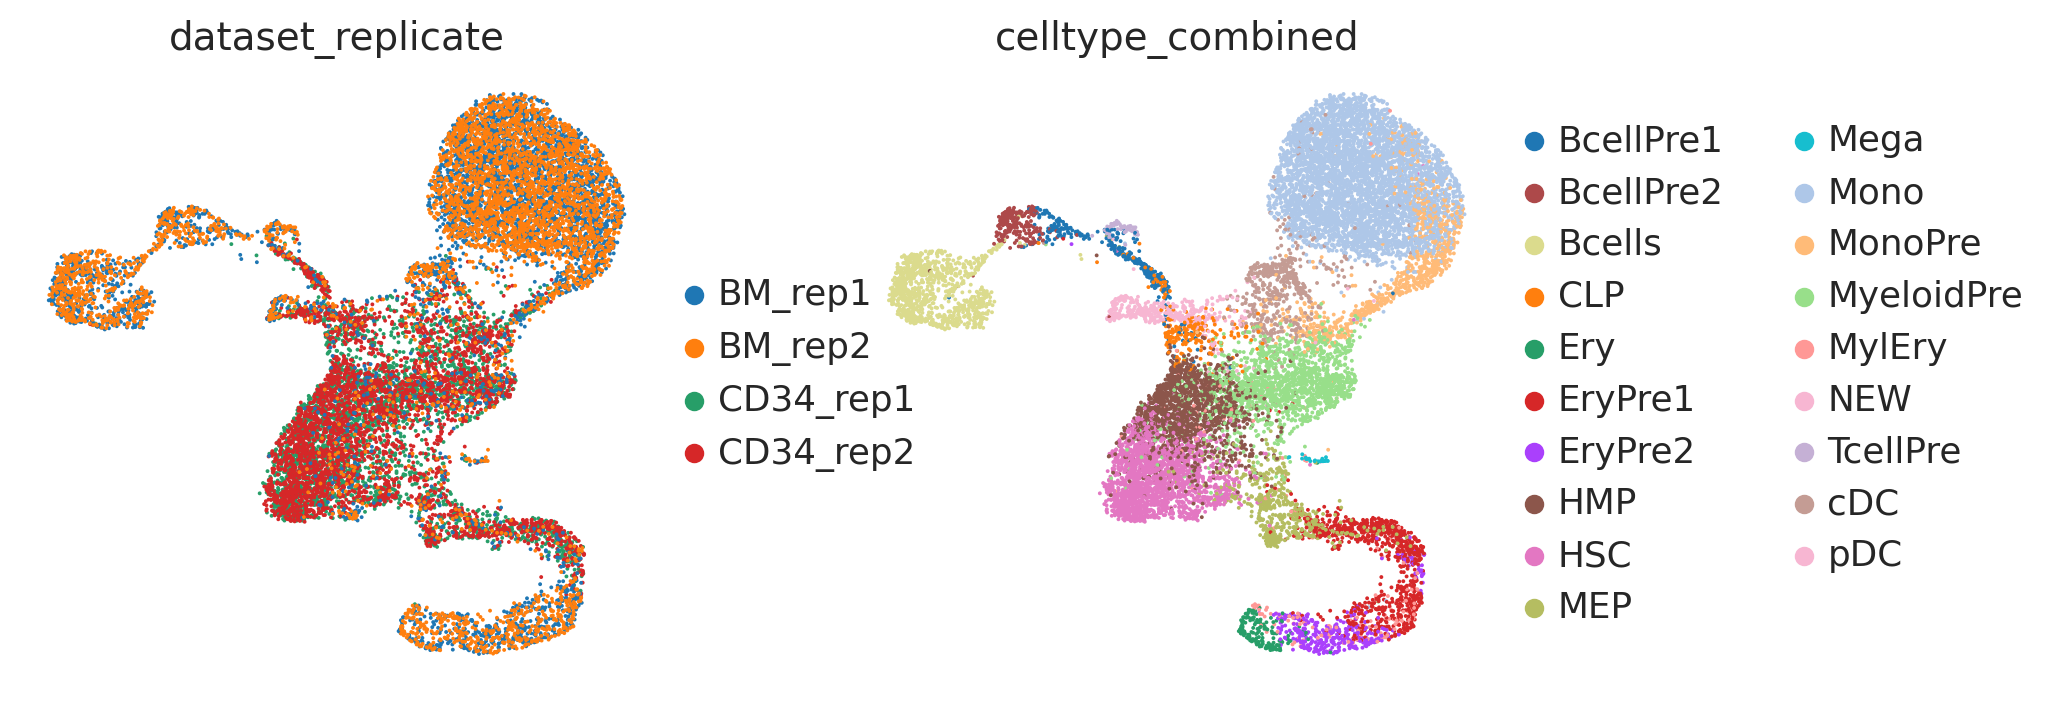

In [6]:
sc.pl.embedding(atac_ad, basis='umap', 
               color=[sample_key, celltype_key])

# Coverage

## Functions

In [7]:
def file_len(fname):
    p = subprocess.Popen(['wc', '-l', fname], stdout=subprocess.PIPE, 
                                              stderr=subprocess.PIPE)
    result, err = p.communicate()
    if p.returncode != 0:
        raise IOError(err)
    return int(result.strip().split()[0])

In [9]:
# Export 
def create_bed_bw_files(fragments_files, out_dir, chrom_sizes,
                        atac_ad, celltype_key, sample_key, celltype_subset=None):
    
    # Cell types
    cell_types = atac_ad.obs[celltype_key].astype(str)
    if celltype_subset is None:
        celltype_subset = cell_types.unique()
    
    # Valid barcodes
    datasets = atac_ad.obs[sample_key].astype(str).unique()
    valid_barcodes = dict()
    cell_types = dict()
    for ds in datasets:
        cells = atac_ad.obs_names[atac_ad.obs[sample_key] == ds]
        cells = cells[atac_ad.obs[celltype_key][cells].isin(celltype_subset)]
        valid_barcodes[ds] = cells.str.split('#').str.get(1)
        cell_types[ds] = pd.Series(atac_ad.obs[celltype_key][cells].values, 
                                   index=valid_barcodes[ds])
    
    print('Creating BED files ....')
    bed_out_dir = f'{out_dir}/bed_files'
    # Chromosome sizes
    chr_sizes = pd.read_csv(chrom_sizes, '\t', index_col=0, header=None).iloc[:, 0]
    chr_sizes = chr_sizes[~chr_sizes.index.str.contains('_')]
    
    
    # Chunk and read per chromosome
    for chrom in chr_sizes.index.difference(['chrM']):
        
        print(f' ++ {chrom}')
        bins = list(np.arange(1, chr_sizes[chrom], 10000000))
        bins.append(chr_sizes[chrom])
        
        for i in range(1, len(bins)):
            region = f'{chrom}:{bins[i-1]}-{bins[i]}'

            # Read fragments
            for sample in fragments_files.keys():
                tb = tabix.open(fragments_files[sample])
                records = tb.querys(region)
                rec_df = pd.DataFrame(records)
                if rec_df.shape[0] == 0:
                    continue
            
                # Valid cell barcodes
                rec_df = rec_df.loc[rec_df[3].isin(valid_barcodes[sample]), :]
                if rec_df.shape[0] == 0:
                    continue
                
                # Fragment sizes
                frag_sizes = rec_df[2].astype(int) - rec_df[1].astype(int)
                nfr_inds = np.where(frag_sizes < 147)[0]
                nuc_inds = np.where(frag_sizes >= 147)[0]

                # Iterate and write to bed files 
                for ct in cell_types[sample].unique():
                    
                    # NFR
                    sub = rec_df.iloc[nfr_inds, :]
                    inds = np.where(cell_types[sample][sub[3]] == ct)[0]
                    sub.iloc[inds, [0, 1, 2]].to_csv(f'{bed_out_dir}/{ct}_NFR.bed',
                                 index=None, header=None, sep='\t', mode='a')

                    
                    # NUC
                    sub = rec_df.iloc[nuc_inds, :]
                    inds = np.where(cell_types[sample][sub[3]] == ct)[0]
                    sub.iloc[inds, [0, 1, 2]].to_csv(f'{bed_out_dir}/{ct}_NUC.bed',
                                 index=None, header=None, sep='\t', mode='a')
                    
                    # All fragments 
                    sub = rec_df
                    inds = np.where(cell_types[sample][sub[3]] == ct)[0]
                    sub.iloc[inds, [0, 1, 2]].to_csv(f'{bed_out_dir}/{ct}_All.bed',
                                 index=None, header=None, sep='\t', mode='a')
                    
                    
                    

    # Scales per organ 
    frag_types = ['NUC', 'NFR', 'All']

    for sample in datasets:
        scales = pd.Series(0.0, index=cell_types[sample].astype(str).unique())
        for ct in scales.index:
            for ft in frag_types:
                scales[ct + '_' + ft] = file_len(f'{bed_out_dir}/{ct}_{ft}.bed')
        scales = 1e6/scales

    
    # Bed graph 
    print('Creating BEDGraph files ....')
    for sample in datasets:
        print(f'   ...for {sample}...')
        for cluster in cell_types[sample].astype(str).unique():
            for ft in frag_types:
                index = f'{cluster}_{ft}'
                print(f' ++ Cluster {index}')
                out_file = open(f'{out_dir}/{cluster}_{ft}.bedGraph', 'w')
                args = ['bedtools', 'genomecov', '-bg', '-i', f'{bed_out_dir}/{index}.bed',
                    '-g',  chrom_sizes, '-scale', str(scales[index])]
                subprocess.call(args, stdout=out_file)
                out_file.close()


In [8]:
def create_bw_files(out_dir, chrom_sizes, atac_ad, celltype_key,
                    sample_key, celltype_subset=None, clean_up=False):
    # Cell types
    cell_types = atac_ad.obs[celltype_key].astype(str)
    if celltype_subset is None:
        celltype_subset = cell_types.unique()
    
    # Valid barcodes
    datasets = atac_ad.obs[sample_key].astype(str).unique()
    valid_barcodes = dict()
    cell_types = dict()
    for ds in datasets:
        cells = atac_ad.obs_names[atac_ad.obs[sample_key] == ds]
        cells = cells[atac_ad.obs[celltype_key][cells].isin(celltype_subset)]
        valid_barcodes[ds] = cells.str.split('#').str.get(1)
        cell_types[ds] = pd.Series(atac_ad.obs[celltype_key][cells].values, 
                                   index=valid_barcodes[ds])
    
    
    frag_types = ['NUC', 'NFR', 'All']
    bw_out_dir = f'{out_dir}/bigwig_files'
    bed_out_dir = f'{out_dir}/bed_files'
    
    # Bigwig file
    print('Creating bigWig files ....')
    for sample in datasets:
        for cluster in cell_types[sample].astype(str).unique():
            for ft in frag_types:
                index = f'{cluster}_{ft}'
                print(f' ++ Cluster {index}')
                args = ['bedGraphToBigWig', f'{out_dir}/{index}.sorted.bedGraph',
                    chrom_sizes, f'{bw_out_dir}/{index}.bw']
                subprocess.call(args)

    
    # Clean up 
    if clean_up:
        print('Cleaning up...')
        for sample in datasets:
            for cluster in cell_types[sample].astype(str).unique():
                for ft in frag_types:
                    os.unlink(f'{out_dir}/{cluster}_{ft}.bedGraph')
                    os.unlink(f'{out_dir}/{cluster}_{ft}.sorted.bedGraph')
                    os.unlink(f'{bed_out_dir}/{cluster}_{ft}.bed')

## Compute coverages

In [ ]:
create_bed_bw_files(fragment_files, out_dir, chromsizes,
                      atac_ad, celltype_key, sample_key, celltype_subset)

Creating BED files ....
 ++ chr1


/loc/scratch/60588879/ipykernel_18732/616774943.py:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  coverage_by_celltype(fragment_files, out_dir, chromsizes,


The next cell will sort the `bedGraph` files for input into the `bedGraphToBigWig` tool

In [94]:
%%bash
# sort bed graph files
out_dir="/fh/scratch/delete10/setty_m/cov/"
cd $out_dir
for fname in ./*.bedGraph
do
    echo "Sorting ${fname}..."
    sorted_name="${fname%.*}.sorted.bedGraph"
    sort -k1,1 -k2,2n $fname > $sorted_name
    echo "Saved to ${sorted_name}"
    echo

done
echo "Done sorting bedGraph files"

Sorting ./C10_STM2457_All.bedGraph...
Saving to ./C10_STM2457_All.sorted.bedGraph

Sorting ./C10_STM2457_NFR.bedGraph...
Saving to ./C10_STM2457_NFR.sorted.bedGraph

Sorting ./C10_STM2457_NUC.bedGraph...
Saving to ./C10_STM2457_NUC.sorted.bedGraph

Sorting ./C11_STM2457_All.bedGraph...
Saving to ./C11_STM2457_All.sorted.bedGraph

Sorting ./C11_STM2457_NFR.bedGraph...
Saving to ./C11_STM2457_NFR.sorted.bedGraph

Sorting ./C11_STM2457_NUC.bedGraph...
Saving to ./C11_STM2457_NUC.sorted.bedGraph

Sorting ./C12_STM2457_All.bedGraph...
Saving to ./C12_STM2457_All.sorted.bedGraph

Sorting ./C12_STM2457_NFR.bedGraph...
Saving to ./C12_STM2457_NFR.sorted.bedGraph

Sorting ./C12_STM2457_NUC.bedGraph...
Saving to ./C12_STM2457_NUC.sorted.bedGraph

Sorting ./C13_STM2457_All.bedGraph...
Saving to ./C13_STM2457_All.sorted.bedGraph

Sorting ./C13_STM2457_NFR.bedGraph...
Saving to ./C13_STM2457_NFR.sorted.bedGraph

Sorting ./C13_STM2457_NUC.bedGraph...
Saving to ./C13_STM2457_NUC.sorted.bedGraph

Sort

In [99]:
create_bw_files(out_dir, chromsizes,atac_ad, 
                celltype_key, sample_key, celltype_subset, clean_up)

Creating bigWig files ....
 ++ Cluster C12_STM2457_NUC
 ++ Cluster C12_STM2457_NFR
 ++ Cluster C12_STM2457_All
 ++ Cluster C14_STM2457_NUC
 ++ Cluster C14_STM2457_NFR
 ++ Cluster C14_STM2457_All
 ++ Cluster C5_STM2457_NUC
 ++ Cluster C5_STM2457_NFR
 ++ Cluster C5_STM2457_All
 ++ Cluster C15_STM2457_NUC
 ++ Cluster C15_STM2457_NFR
 ++ Cluster C15_STM2457_All
 ++ Cluster C8_STM2457_NUC
 ++ Cluster C8_STM2457_NFR
 ++ Cluster C8_STM2457_All
 ++ Cluster C6_STM2457_NUC
 ++ Cluster C6_STM2457_NFR
 ++ Cluster C6_STM2457_All
 ++ Cluster C11_STM2457_NUC
 ++ Cluster C11_STM2457_NFR
 ++ Cluster C11_STM2457_All
 ++ Cluster C3_STM2457_NUC
 ++ Cluster C3_STM2457_NFR
 ++ Cluster C3_STM2457_All
 ++ Cluster C2_STM2457_NUC
 ++ Cluster C2_STM2457_NFR
 ++ Cluster C2_STM2457_All
 ++ Cluster C13_STM2457_NUC
 ++ Cluster C13_STM2457_NFR
 ++ Cluster C13_STM2457_All
 ++ Cluster C7_STM2457_NUC
 ++ Cluster C7_STM2457_NFR
 ++ Cluster C7_STM2457_All
 ++ Cluster C10_STM2457_NUC
 ++ Cluster C10_STM2457_NFR
 ++ Cluster

# Peaks

In [ ]:
def pyranges_from_strings(pos_list):
    # Chromosome and positions
    chr = pos_list.str.split(':').str.get(0)
    start = pd.Series(pos_list.str.split(':').str.get(1)).str.split('-').str.get(0)
    end = pd.Series(pos_list.str.split(':').str.get(1)).str.split('-').str.get(1)
    
    # Create ranges
    gr = pr.PyRanges(chromosomes=chr, starts=start, ends=end)
    
    return gr

In [ ]:
peaks = pyranges_from_strings(atac_ad.var_names)

In [ ]:
peaks.to_bed(out_dir + 'peaks.bed')